In [1]:
# Object detection demo
# Welcome to the object detection inference walkthrough! This notebook will walk you step by step through
# the process of using pre-trained model to detect objects in an image

In [4]:
# Install necessary dependencies
!python3 -m pip install --upgrade pip
!pip install --upgrade keras-cv
!pip install --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os 
os.environ['KERAS_BACKEND'] = 'jax'

import tensorflow as tf

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import tensorflow.keras
import keras_cv
import keras
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

2024-04-20 08:40:30.702554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# 详细细节可参考: https://keras.io/guides/keras_cv/object_detection_keras_cv/

# Let's get started by constructing a YOLOV8Detector pretrained on the pascalvoc dataset.
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)


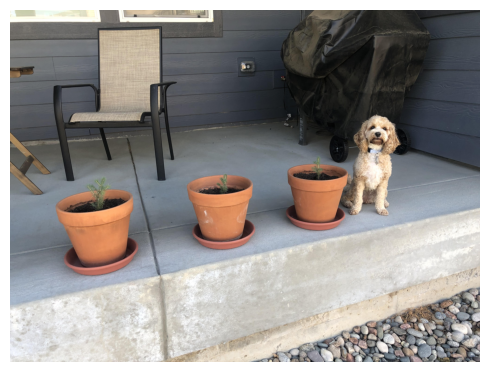

In [4]:
file_path = './images/dog_pic.jpeg'
image = keras.utils.load_img(file_path)
image = np.array(image)
visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,);

In [5]:
# Resize the image to the model compat input size
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format='xywh'
)

# This can be used as our inference preprocessing pipeline:
image_batch = inference_resizing([image])

2024-04-20 08:40:50.990189: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 146313216 exceeds 10% of free system memory.


In [6]:
# keras_cv.visualization.plot_bounding_box_gallery() supports a class_mapping parameter to
# highlight what class each box was assigned to. Let's assemble a class mapping now.

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [7]:
class_mapping

{0: 'Aeroplane',
 1: 'Bicycle',
 2: 'Bird',
 3: 'Boat',
 4: 'Bottle',
 5: 'Bus',
 6: 'Car',
 7: 'Cat',
 8: 'Chair',
 9: 'Cow',
 10: 'Dining Table',
 11: 'Dog',
 12: 'Horse',
 13: 'Motorbike',
 14: 'Person',
 15: 'Potted Plant',
 16: 'Sheep',
 17: 'Sofa',
 18: 'Train',
 19: 'Tvmonitor',
 20: 'Total'}

In [8]:
# Just like any other keras.Model you can predict bounding boxes using the model.predict() API.
y_pred = pretrained_model.predict(image_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [8]:
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}

y_pred

y_pred['boxes]

{'boxes': array([[[449.51062 , 142.71707 ,  90.91394 , 141.12839 ],
         [374.7498  , 206.06046 ,  86.41055 ,  94.26883 ],
         [ 59.679283, 229.16298 , 114.07429 , 130.60637 ],
         [238.03308 , 223.13684 ,  95.84607 , 102.32648 ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  

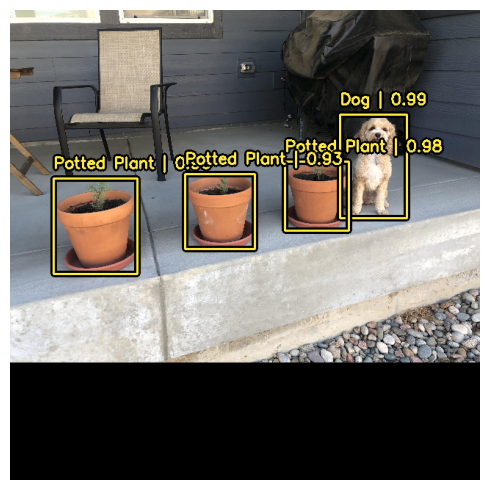

In [10]:
visualization.plot_bounding_box_gallery(image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xywh',
    class_mapping=class_mapping
);

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


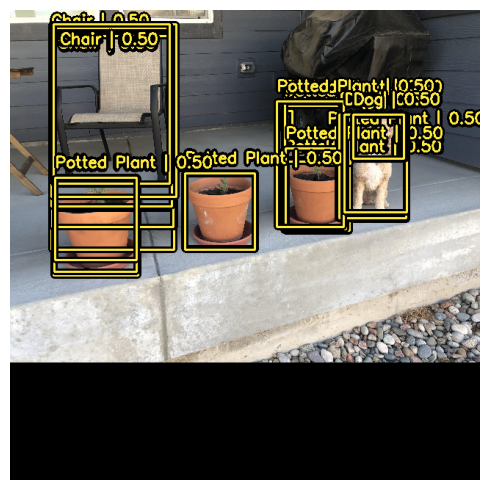

In [12]:
# 扩展: 上面已经完成prediction了，play with NonMaxSupression参数
# The following NonMaxSuppression layer is equivalent to disabling the operation
# 为啥是disable? 因为iou设置为1，表示只有当两者完全重合才去抑制他
# confidence设置成0，表示不管置信度多低，都不抑制他，都相信他
# 这样一弄就会出来一大坨
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format='xywh',
    from_logits=True,
    iou_threshold=1,
    confidence_threshold=0.0,
)

pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format='xywh',
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
);


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


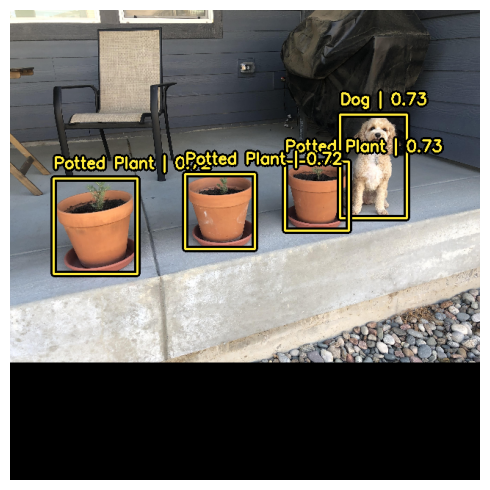

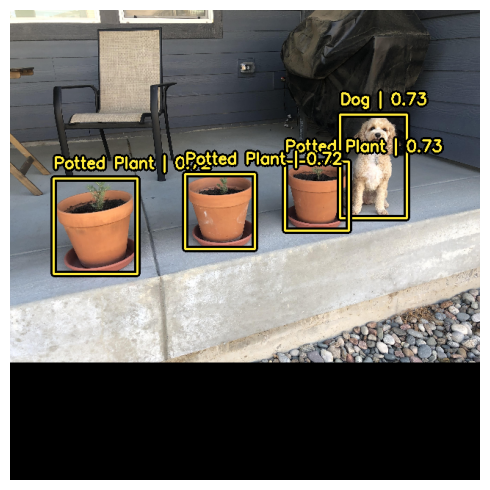

In [18]:
# Next, let's re-configure keras_cv.layers.NonMaxSuppression for our use case!
# In this case, we will tune the iou_threshold to 0.2, and the confidence_threshold to 0.7.

prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format='xywh',
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.7,
)

pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format='xywh',
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)

image = visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
);

image


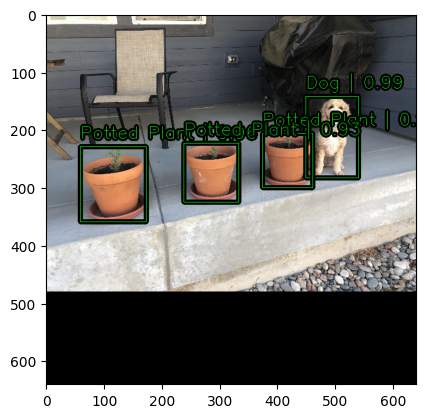

In [16]:
# 下面这个图就可以save了
image_with_boxes = visualization.draw_bounding_boxes(image_batch,
    bounding_boxes=y_pred,
    color = (0, 255, 0),
    bounding_box_format="xywh",
    class_mapping=class_mapping, )

image_with_boxes = image_with_boxes.reshape(640, 640, 3)
plt.imshow(image_with_boxes)
